In [1]:
import os
import uuid

os.environ['HF_HOME'] = 'hf_cache'

import matplotlib.pyplot as plt

from model.modeling_llama import LlamaForCausalLM as ModifiedLlama
from transformers import AutoTokenizer, AutoModelForCausalLM
from kvcache.iterative import IterativeReduceKVBiasCache as ModifiedCache
from transformers import DynamicCache
from datasets import load_dataset

import torch
import numpy as np
import random

import torch.nn.functional as F
import time
from IPython.display import DisplayHandle

import os
import random
import pandas as pd

import seaborn as sns

DEVICE = 'mps'
DTYPE = torch.float32
FIRST_N = 10000

BATCH_SIZE = 16
SAMPLE_SIZE = 16
MAX_LENGTH = 500
N_SEEDED = 1

PROTECT_FIRST = 20
ROLLING_WINDOW = 50

In [2]:
torch.cuda.is_available()

False

In [3]:
# Define the cache file name
CACHE_FILENAME = f"fineweb_sample{SAMPLE_SIZE}of{FIRST_N}.csv"

# Check if the cache file already exists
if os.path.exists(CACHE_FILENAME):
    print(f"Cache file already exists: {CACHE_FILENAME}")
    df = pd.read_csv(CACHE_FILENAME)
else:
    # Load streaming dataset
    dataset = load_dataset("HuggingFaceFW/fineweb-edu", split="train", name="sample-10BT", streaming=True)
    stream = iter(dataset)

    samples = [next(stream) for _ in range(FIRST_N)]
    selected_samples = random.sample(samples, SAMPLE_SIZE)

    # Convert to DataFrame
    df = pd.DataFrame(selected_samples)

    # Save to CSV
    df.to_csv(CACHE_FILENAME, index=False, encoding="utf-8")
    print(f"Saved CSV with {len(df)} samples to: {CACHE_FILENAME}")

texts = df["text"]

Cache file already exists: fineweb_sample16of10000.csv


In [17]:
def get_cache_size(cache: DynamicCache | ModifiedCache, max_len: int):
    n_layers = len(cache.key_cache)
    n_heads = len(cache.key_cache[0][0])
    n_exmpl = len(cache.key_cache[0])
    
    if not isinstance(cache, ModifiedCache):
        for i in range(n_exmpl):
            yield {'Cache Size (% of max)': 100}
    else:
        layer_sum = 0
        n_layers = 0
        for layer, last_available_per_head in enumerate(cache.last_available_idx):
            ratio = torch.max(last_available_per_head, dim=-1)[0] / max_len
            layer_sum += ratio * 100
            n_layers += 1
        
        mean = layer_sum / n_layers
        for i in range(n_exmpl):
            yield {'Cache Size (% of max)': mean[i].item()}


def eval_match_ignored_order(pred: set[int], gold: set[int]) -> float:
    same = gold.intersection(pred)
    return 100 * len(same) / len(gold)
                

def stepwise_perplexity(
        model, tokenizer, texts, cache_impl, 
        gold: list[set[int]] = None, 
        update_every=1, 
        max_length=MAX_LENGTH,
        seed_run: bool = False,
        step_size: int = 1,
):
    MS = step_size
    loss_fn = torch.nn.CrossEntropyLoss(reduction='none')

    total_texts = len(texts)

    display_handle = DisplayHandle()
    display_handle.display("Starting perplexity evaluation...")
    
    # track: PPL, Text Idx, Step, Cache Class
    results = []
    
    # track: Cache Size (% of max), Layer ID, Head ID, Text Idx, Step
    results_cache = []

    gold_iter = iter(gold) if gold is not None else None
    
    seed_tokens = torch.tensor([], dtype=torch.long)
    if seed_run:
        seed = '<text_uid>' + str(uuid.uuid4()) + '</text_uid>\n\n'
        seed_tokens = tokenizer([seed], return_tensors="pt", truncation=True, max_length=max_length)["input_ids"]
        
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    total_batches = (len(texts) // BATCH_SIZE) + bool(len(texts) % BATCH_SIZE)
    for batch_idx in range(total_batches):
        batch_texts = list(texts[batch_idx * BATCH_SIZE:(batch_idx + 1) * BATCH_SIZE])
        enc = tokenizer(batch_texts, return_tensors="pt", truncation=True, max_length=max_length, padding=True)
        new_input_ids = enc["input_ids"]
        B = new_input_ids.size(0)
        input_ids = torch.concat([seed_tokens.expand(B, -1), enc["input_ids"]], dim=-1).to(DEVICE)
        cache = cache_impl()
        
        extra_info = {}
        cache_class_extended = None
        if isinstance(cache, ModifiedCache):
            cache_class_extended = cache.__class__.__name__ + f"(MVI={cache.max_mvi:.1f})"
            cache_class = cache.__class__.__name__
            extra_info = {
                'MVI': cache.max_mvi,
                'OF': step_size
            }
        else:
            cache_class = "Normal"
            extra_info = {
                'MVI': 'N/A',
                'OF': 'N/A'
            }
        
        if seed_run:
            cache_class += " Seeded"
        
        if cache_class_extended is None:
            cache_class_extended = cache_class
        
        S = input_ids.size(1)
        
        total_loss = 0.0
        total_tokens = 0
        
        skip_count = 0
        if seed_run:
            skip_count = seed_tokens.size(1)

        # Autoregressive token-by-token loop
        for i in range(1, (S // MS) + 1):
            start = (i - 1) * MS
            end = min(i * MS, S - 1)
            input_slice  = input_ids[:, start : end]          # [B, MS]
            label_tokens = input_ids[:, start + 1: end + 1] # [B, MS]
            
            curr_MS = end - start
            if not curr_MS:
                continue

            with torch.no_grad():
                output = model(
                    input_ids=input_slice,
                    use_cache=True,
                    past_key_values=cache,
                    cache_position=torch.arange(start, end, device=DEVICE, dtype=torch.long),
                )
                cache = output.past_key_values
                logits = output.logits # [B, MS, vocab_size]
                
            if skip_count <= 0:
                loss = loss_fn(logits.reshape(-1, logits.size(-1)), label_tokens.reshape(-1))
                total_loss += loss.sum().cpu().numpy()
                total_tokens += B * curr_MS
                
                top_5 = logits.topk(k=5, dim=-1)[1]
                
                # Update the display every update_every steps
                if total_tokens % update_every == 0 or (i == S - 1 and batch_idx == total_batches - 1):
                    current_ppl = np.exp(total_loss / total_tokens)
                    status = (f"Batch {batch_idx + 1}/{total_batches} | "
                              f"Step {i + 1}/{S // MS} | "
                              f"Cumulative PPL: {float(current_ppl.mean()):.2f}")
                    display_handle.update(status)
            
                for local_text_idx in range(B):
                    text_idx = batch_idx * BATCH_SIZE + local_text_idx
                    
                    for local_token_idx in range(curr_MS):
                        assert tokenizer.pad_token_id is not None
                        if label_tokens[local_text_idx, local_token_idx].item() == tokenizer.pad_token_id:
                            continue
                        local_top_5 = top_5[local_text_idx, local_token_idx].tolist()
                        token_idx = (i - 1) * MS + local_token_idx
                    
                        # Append current results:
                        # For each token, we collect the current perplexity estimate, the cache class, 
                        # the text index, and the current step number.
                        step_idx = token_idx - (seed_tokens.size(1) if seed_run else 0)
                        results.append({
                            "Top 5 Tokens": local_top_5,
                            "MatchUnordered@5": eval_match_ignored_order(
                                set(local_top_5), 
                                gold[text_idx][step_idx]
                            ) if gold is not None else 100.0,
                            "Cache Class": cache_class,
                            "Cache Class (Ext.)": cache_class_extended,
                            "Text Idx": text_idx,
                            "Step": step_idx,
                            **extra_info
                        })
                    
                    results_cache.extend([
                            {
                            "Text Idx": text_idx,
                            "Step": (i - 1) * MS + curr_MS - (seed_tokens.size(1) if seed_run else 0),
                            "Cache Class": cache_class,
                            **d,
                            **extra_info
                        }
                        for d in get_cache_size(cache, max_len=end)  
                    ])
                
            skip_count -= 1

    return results, results_cache

def get_gold(res: list[dict]) -> list[list[set]]:
    result = []
    data = pd.DataFrame(res).groupby(["Text Idx", "Step"])
    for i, datapoint in data:
        text_idx = int(datapoint["Text Idx"].iloc[0])
        step = int(datapoint["Step"].iloc[0])
        while len(result) <= text_idx:
            result.append([])
        target = result[text_idx]
        while len(target) <= step:
            target.append(None)
        target[step] = set(datapoint["Top 5 Tokens"].iloc[0])
    return result

In [18]:
def plot(data, target="PPL", ylim=None, rolling_window=None, hue='MVI'):
    """
    Plots the specified target over steps from the given data. Optionally 
    applies a window-based rolling mean to smooth the plot.

    :param data: List of dictionaries or a Pandas DataFrame that must include
                 columns 'Step', 'Cache Class', and <target>.
    :param target: The target column to plot (e.g. "PPL").
    :param ylim: A tuple (min, max) that specifies the y-axis range.
    :param smoothing_window: Size of the rolling window for smoothing. If set 
                            to None, no smoothing is applied.
    """
    df = pd.DataFrame(data)

    # Optionally apply smoothing
    if rolling_window is not None and rolling_window > 1:
        df[target] = df.groupby(["Cache Class", "Text Idx"])[target] \
                       .transform(lambda s: s.rolling(rolling_window, min_periods=1).mean())

    plt.figure(figsize=(12, 7))
    sns.lineplot(x="Step", y=target, style="Cache Class", hue=hue, data=df)
    if ylim:
        plt.ylim(ylim)
    plt.title(f"{target} vs. Step" + (f" (Rolling Window = {rolling_window})" if rolling_window else ""))
    plt.show()
    
    
def plot_cache(data, hue='MVI'):
    plt.figure(figsize=(12, 7))
    sns.lineplot(y="Cache Size (% of max)", x="Step", data=pd.DataFrame(data), style="Cache Class", hue=hue)

In [13]:
#texts = [texts[0]]

In [14]:
model_hf = AutoModelForCausalLM.from_pretrained("HuggingFaceTB/SmolLM2-135M")
model_hf.eval().to(DEVICE).to(DTYPE)

tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM2-135M")

In [8]:
results, results_cache = stepwise_perplexity(model_hf, tokenizer, texts, cache_impl=lambda: None, step_size=10)
gold = get_gold(results)
gold[0][:10], len(gold)

'Batch 1/1 | Step 51/50 | Cumulative PPL: 24.88'

([{768, 808, 905, 1142, 1596},
  {29, 282, 284, 5495, 10124},
  {28, 42, 198, 282, 2384},
  {216, 327, 429, 578, 1699},
  {216, 253, 260, 563, 582},
  {81, 95, 473, 7598, 13706},
  {28, 281, 288, 335, 365},
  {260, 288, 582, 624, 6476},
  {288, 417, 506, 5378, 7216},
  {28, 281, 288, 1187, 4081}],
 16)

In [15]:
model_mod = ModifiedLlama.from_pretrained("HuggingFaceTB/SmolLM2-135M", attn_implementation="eager")
model_mod.eval().to(DEVICE).to(DTYPE)

tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM2-135M")

In [ ]:
import copy
results_sf, results_cache_sf = copy.deepcopy(results), copy.deepcopy(results_cache)
for step_freq in [1, 2, 4, 8, 16, 32]:
    res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(max_mvi=30.0), step_size=step_freq)
    results_sf += res
    results_cache_sf += resc

plot(results_sf, target="MatchUnordered@5", rolling_window=ROLLING_WINDOW, hue='OF')
plot_cache(results_cache_sf, hue='OF')

'Batch 1/1 | Step 181/500 | Cumulative PPL: 19.50'

'Batch 1/1 | Step 100/100 | Cumulative PPL: 25.32'

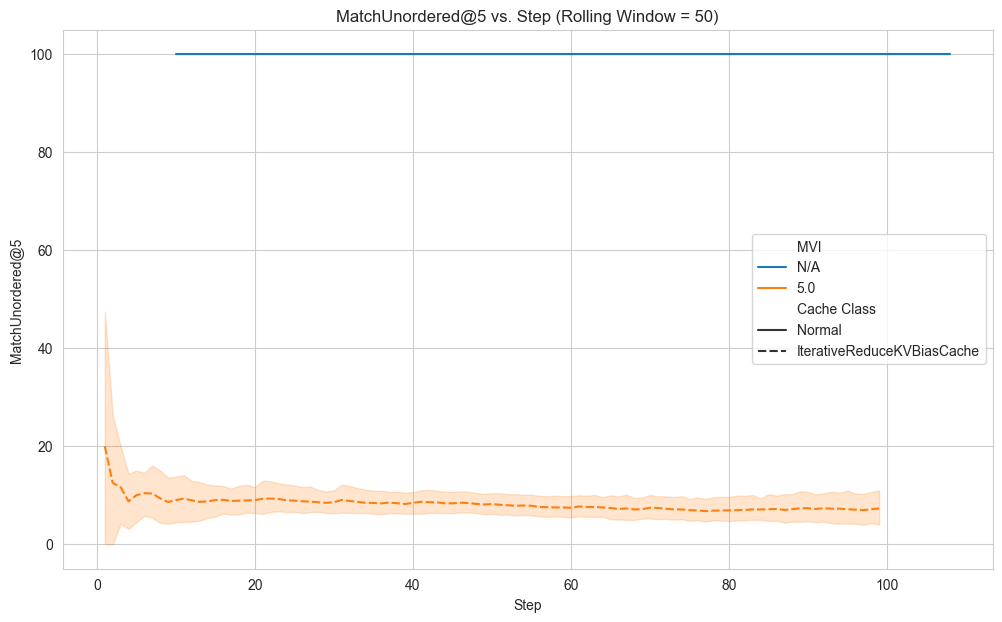

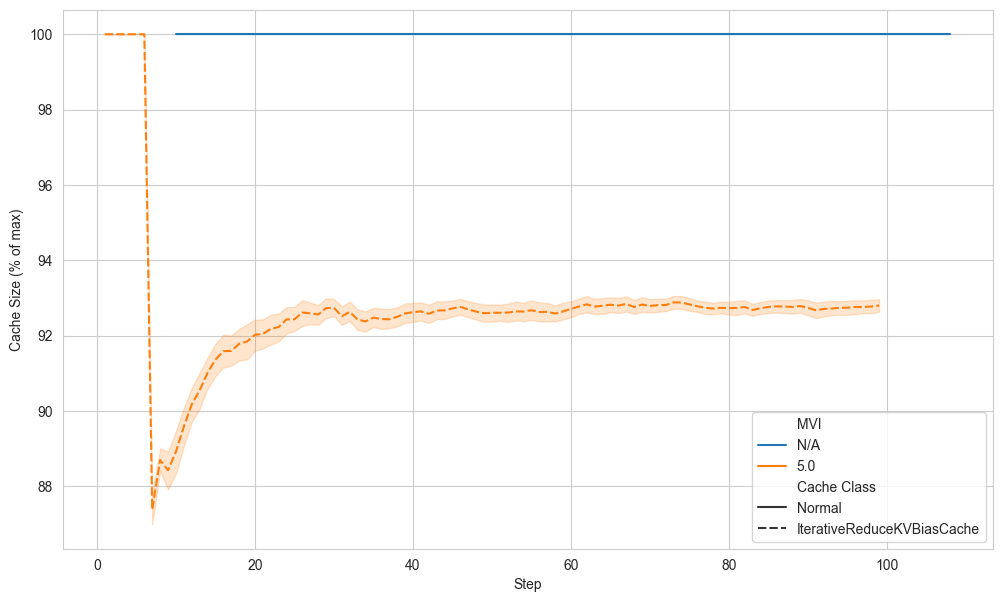

In [11]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(max_mvi=5.0))
results += res
results_cache += resc
plot(results, target="MatchUnordered@5", rolling_window=ROLLING_WINDOW)
plot_cache(results_cache)

In [ ]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(max_mvi=5.0))
results += res
results_cache += resc
plot(results, target="MatchUnordered@5", rolling_window=ROLLING_WINDOW)
plot_cache(results_cache)

In [ ]:
# compute normal variations of the metric
for _ in range(N_SEEDED):
    res, resc = stepwise_perplexity(model_hf, tokenizer, texts, gold=gold, cache_impl=lambda: None, seed_run=True)
    results += res
    results_cache += resc
    
plot(results, target="MatchUnordered@5", rolling_window=ROLLING_WINDOW)
plot_cache(results_cache)

'Batch 1/1 | Step 100/100 | Cumulative PPL: 25.82'

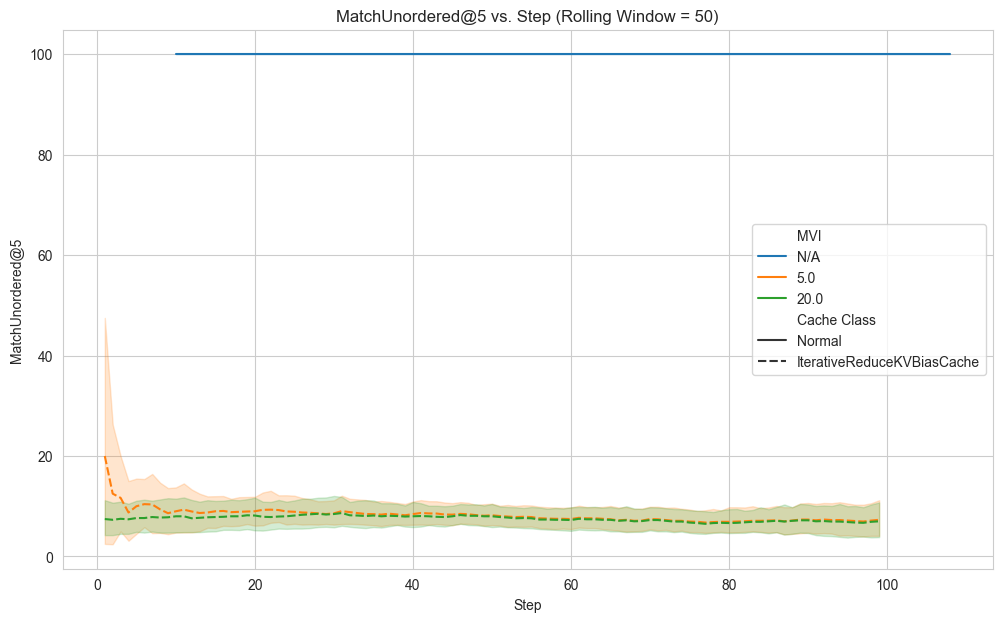

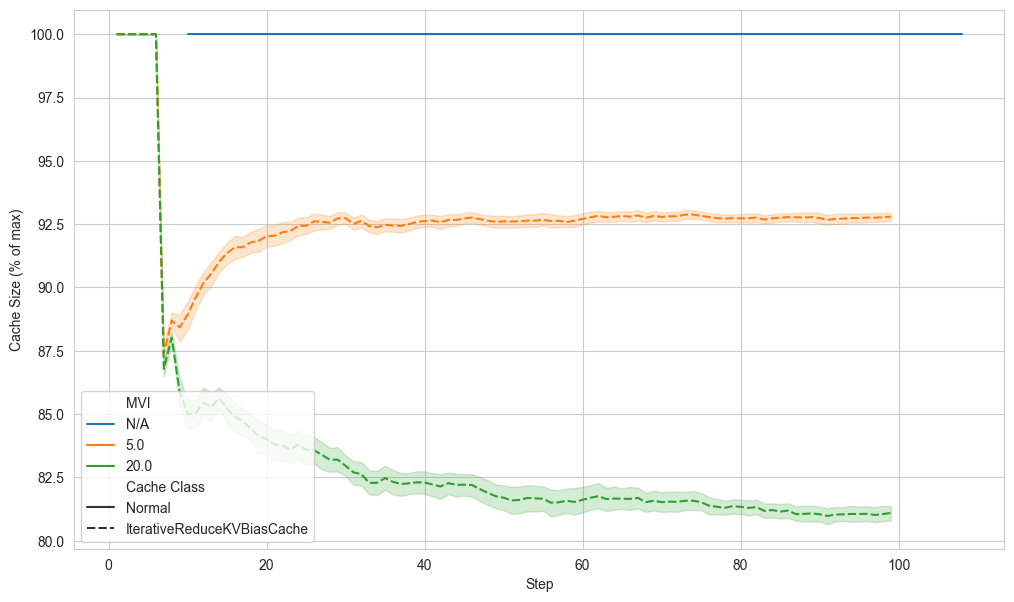

In [12]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(max_mvi=20.0))
results += res
results_cache += resc
plot(results, target="MatchUnordered@5", rolling_window=ROLLING_WINDOW)
plot_cache(results_cache)

In [ ]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(max_mvi=40.0))
results += res
results_cache += resc
plot(results, target="MatchUnordered@5", rolling_window=ROLLING_WINDOW)
plot_cache(results_cache)

'Batch 1/1 | Step 11/10 | Cumulative PPL: 21.80'

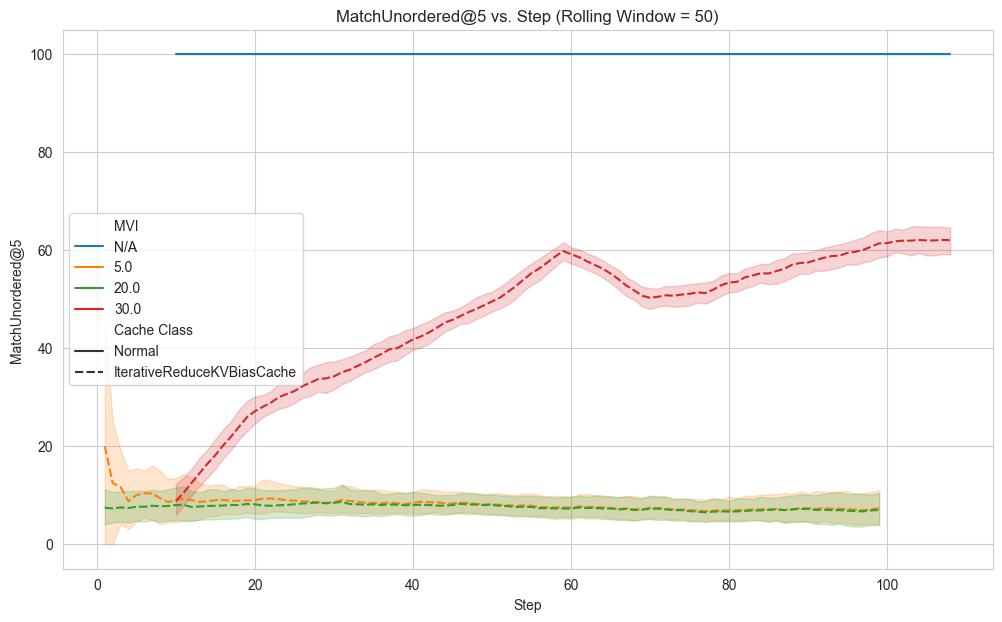

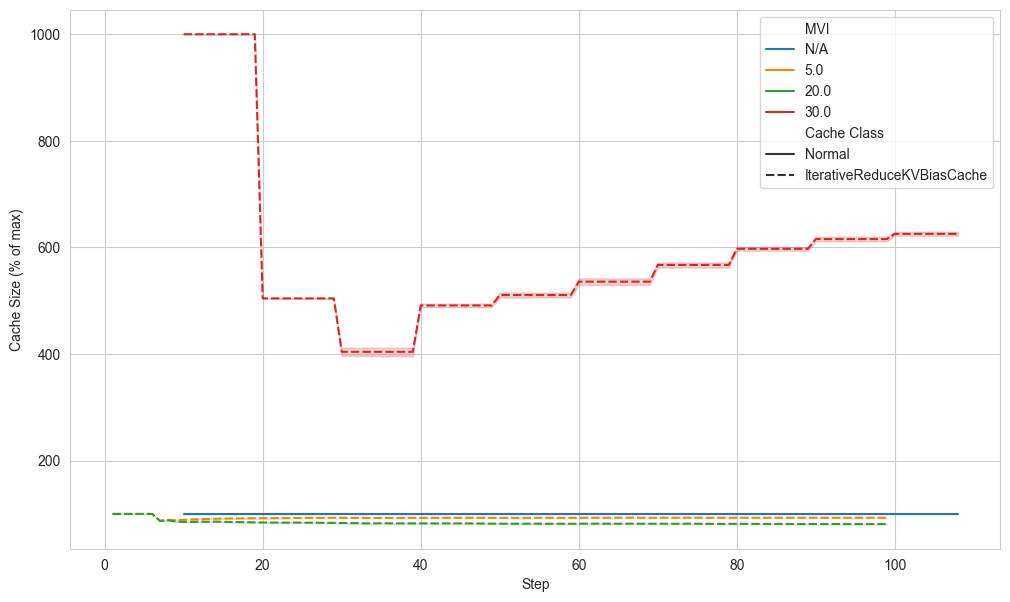

In [13]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(max_mvi=30.0), step_size=10)
results += res
results_cache += resc
plot(results, target="MatchUnordered@5", rolling_window=ROLLING_WINDOW)
plot_cache(results_cache)

In [ ]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(max_mvi=50.0))
results += res
results_cache += resc
plot(results, target="MatchUnordered@5", rolling_window=ROLLING_WINDOW)
plot_cache(results_cache)

In [ ]:
MODEL = 'meta-llama/Meta-Llama-3-8B'
model_hf = AutoModelForCausalLM.from_pretrained(MODEL)
model_hf.eval().to(DEVICE).to(DTYPE)

tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [ ]:
results, results_cache = stepwise_perplexity(model_hf, tokenizer, texts, cache_impl=lambda: None)
gold = get_gold(results)
gold[:10]

In [ ]:
model_mod = ModifiedLlama.from_pretrained(MODEL, attn_implementation="eager")
model_mod.eval().to(DEVICE).to(DTYPE)

tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [ ]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(max_mvi=10.0))
results += res
results_cache += resc
plot(results, target="MatchUnordered@5")
plot_cache(results_cache)

In [ ]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(max_mvi=20.0))
results += res
results_cache += resc
plot(results, target="MatchUnordered@5")
plot_cache(results_cache)

In [ ]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(max_mvi=30.0))
results += res
results_cache += resc
plot(results, target="MatchUnordered@5")
plot_cache(results_cache)

In [ ]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(max_mvi=50.0))
results += res
results_cache += resc
plot(results, target="MatchUnordered@5")
plot_cache(results_cache)

In [ ]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(max_mvi=100.0))
results += res
results_cache += resc
plot(results, target="MatchUnordered@5")
plot_cache(results_cache)

In [ ]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(max_mvi=120.0))
results += res
results_cache += resc
plot(results, target="MatchUnordered@5")
plot_cache(results_cache)

In [ ]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(max_mvi=150.0))
results += res
results_cache += resc
plot(results, target="MatchUnordered@5")
plot_cache(results_cache)

In [ ]:
print(texts[0])

In [ ]:
def stepwise_generate(model, tokenizer, prompt, cache_impl, update_every=10, n_generate=100, top_n=10):
    display_handle = DisplayHandle()
    display_handle.display("Starting generation...")

    enc = tokenizer(prompt, return_tensors="pt")
    input_ids = enc["input_ids"].squeeze(0).to(model.device)
    cache = cache_impl()
    
    seq_len = input_ids.size(0)

    # Autoregressive token-by-token loop
    for i in range(1, seq_len + n_generate):
        input_slice = input_ids[i - 1 : i].unsqueeze(0)  # [1, 1]

        with torch.no_grad():
            output = model(
                input_ids=input_slice,
                use_cache=True,
                past_key_values=cache,
                cache_position=torch.tensor([i - 1], device=model.device, dtype=torch.long),
            )
            cache = output.past_key_values
            logits = output.logits[0, -1, :]  # [vocab_size]

            # Get the top 'top_n' tokens and their corresponding probabilities
            top_n_logits, top_n_indices = torch.topk(logits, top_n)
            top_n_probs = torch.softmax(top_n_logits, dim=-1)
            predicted_token = top_n_indices[torch.multinomial(top_n_probs, num_samples=1)]

            if i >= seq_len:
                input_ids = torch.cat((input_ids, predicted_token), dim=-1)

        # Update the display every update_every steps
        if i % update_every == 0 or i == seq_len + n_generate - 1:
            status = tokenizer.decode(input_ids)
            display_handle.update(status)
    
    if isinstance(cache, ModifiedCache):
        print(100 * (torch.stack(cache.last_available_idx) / (seq_len + n_generate)).mean().item(), '%')

In [ ]:
stepwise_generate(model_mod, tokenizer, "Once upon a time, ", cache_impl=lambda: ModifiedCache(max_mvi=1.0))

In [ ]:
stepwise_generate(model_mod, tokenizer, "Once upon a time, ", cache_impl=lambda: ModifiedCache(max_mvi=5.0))

In [ ]:
stepwise_generate(model_mod, tokenizer, "Once upon a time, ", cache_impl=lambda: ModifiedCache(max_mvi=10.0))

In [ ]:
stepwise_generate(model_mod, tokenizer, "Once upon a time, ", cache_impl=lambda: ModifiedCache(max_mvi=20.0))

In [ ]:
stepwise_generate(model_mod, tokenizer, "Once upon a time, ", cache_impl=lambda: ModifiedCache(max_mvi=30.0))

In [ ]:
stepwise_generate(model_mod, tokenizer, "Once upon a time, ", cache_impl=lambda: ModifiedCache(max_mvi=40.0))

In [ ]:
stepwise_generate(model_mod, tokenizer, "Once upon a time, ", cache_impl=lambda: ModifiedCache(max_mvi=50.0))

In [ ]:
stepwise_generate(model_mod, tokenizer, "Once upon a time, ", cache_impl=lambda: ModifiedCache(max_mvi=70.0))

In [ ]:
stepwise_generate(model_mod, tokenizer, "Once upon a time, ", cache_impl=lambda: ModifiedCache(max_mvi=100.0))

In [ ]:
stepwise_generate(model_mod, tokenizer, "Once upon a time, ", cache_impl=lambda: None)

In [ ]:
stepwise_generate(model_mod, tokenizer, "Once upon a time, ", cache_impl=lambda: None)

In [ ]:
stepwise_generate(model_mod, tokenizer, "Once upon a time, ", cache_impl=lambda: None)

In [ ]:
stepwise_generate(model_mod, tokenizer, "Once upon a time, ", cache_impl=lambda: None)

In [ ]:
stepwise_generate(model_mod, tokenizer, "Once upon a time, ", cache_impl=lambda: None)